# Lab 18: Clustering

In this lab you will explore K-Means, Agglomerative Clustering, and (optionally) Spectral Clustering. 

In [1]:
import numpy as np 
import pandas as pd # don't you know Pandas?
import matplotlib.pyplot as plt # plots
import seaborn as sns # pretty plots
from sklearn import cluster

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.



In the first part of this lab, we work with three different toy datasets, all with different clustering characteristics. In the second part, we explore a real-world dataset from the World Bank.

<br/><br/><br/>

## Toy Data 1: Balanced Clusters

Let us begin with a toy dataset with three groups that are completely separated with the variables given. There are the same number of points per group and the same variance within each group.

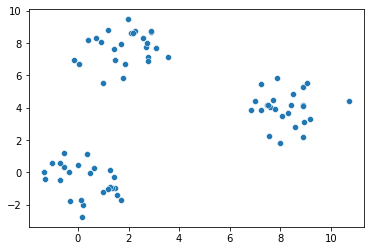

In [2]:
# just run this cell
np.random.seed(1337)

c1 = np.random.normal(size = (25, 2))
c2 = np.array([2, 8]) + np.random.normal(size = (25, 2))
c3 = np.array([8, 4]) + np.random.normal(size = (25, 2))

x1 = np.vstack((c1, c2, c3))

sns.scatterplot(x = x1[:, 0], y = x1[:, 1]);

Below, we create a `cluster.KMeans` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) which implements the K-Means algorithm.

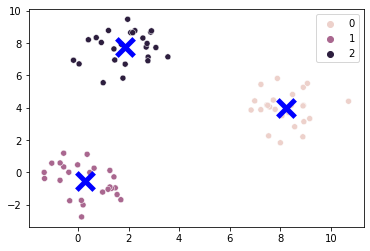

In [3]:
# just run this cell
kmeans = cluster.KMeans(n_clusters = 3, random_state = 42).fit(x1)
sns.scatterplot(x = x1[:, 0], y = x1[:, 1], hue = kmeans.labels_)
sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1], color = 'blue', marker = 'x', s = 300, linewidth = 5);

We observe that K-Means is able to accurately pick out the three initial clusters. 

<br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Question 1: Initial Centers

In the previous example, the K-Means algorithm was able to accurately find the three initial clusters. However, changing the starting centers for K-Means can change the final clusters that K-Means gives us. Change the initial centers to the points `[0, 1]`, `[1, 1]`, and `[2, 2]`; and fit a `cluster.KMeans` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) called `kmeans_q1` on the toy dataset from the previous example. Keep the `random_state` parameter as 42 and the `n_clusters` parameter as 3.

**Hint:** You will need to change the `init` and `n_init` parameters in `cluster.KMeans`.

<!--
BEGIN QUESTION
name: q1
-->

In [ ]:
kmeans_q1 = ...

In [ ]:
# Test for q1 - should say True
sorted(np.unique(kmeans_q1.labels_, return_counts = True)[1]) == [12, 13, 50]

Running the K-Means algorithm with these centers gives us a different result from before, and this particular run of K-Means was unable to accurately find the three initial clusters.

In [ ]:
sns.scatterplot(x = x1[:, 0], y = x1[:, 1], hue = kmeans_q1.labels_)
sns.scatterplot(x = kmeans_q1.cluster_centers_[:, 0], y = kmeans_q1.cluster_centers_[:, 1], color = 'blue', marker = 'x', s = 300, linewidth = 5);

<br/><br/><br/>

<hr style="border: 5px solid #311432;" />
<hr style="border: 1px solid #fdb515;" />

## Toy Data 2: Clusters of Different Sizes

Sometimes, K-Means will have a difficult time finding the "correct" clusters even with ideal starting centers. For example, consider the data below.

In [ ]:
# just run this cell
np.random.seed(1337)

c1 = 0.5 * np.random.normal(size = (25, 2))
c2 = np.array([10, 10]) + 3 * np.random.normal(size = (475, 2))

x2 = np.vstack((c1, c2))

sns.scatterplot(x = x2[:, 0], y = x2[:, 1]);

There are two groups of different sizes in two different senses: **variability** (i.e., spread) and **number of datapoints**. The smaller group has both smaller variability and has fewer datapoints, and the larger of the two groups is more diffuse and populated.

<br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Question 2

### Question 2a: K-Means

Fit a `cluster.KMeans` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) called `kmeans_q2a` on the dataset above with two clusters and a `random_state` parameter of 42.

<!--
BEGIN QUESTION
name: q2a
-->

In [ ]:
kmeans_q2a = cluster.KMeans(n_clusters = 2, random_state = 42).fit(x2)

In [ ]:
# Test for Q2a
sorted(np.unique(kmeans_q2a.labels_, return_counts = True)[1]) == [45, 455]

<br/>

(For notational simplicity we will call the initial cluster on the bottom left $A$ and the initial cluster on the top right $B$. We will call the bottom left cluster found by K-Means as cluster $a$ and the top right cluster found by K-Means as cluster $b$.) 

As seen below, K-Means is unable to find the two intial clusters because cluster $A$ includes points from cluster $B$. Recall that K-Means attempts to minimize inertia, so it makes sense that points in the bottom left of cluster $B$ would prefer to be in cluster $A$ rather than cluster $B$. If these points were in cluster $B$ instead, then the resulting cluster assignments would have a larger distortion.

In [ ]:
# just run this cell
sns.scatterplot(x = x2[:, 0], y = x2[:, 1], hue = kmeans_q2a.labels_)
sns.scatterplot(x = kmeans_q2a.cluster_centers_[:, 0], y = kmeans_q2a.cluster_centers_[:, 1], color = 'red', marker = 'x', s = 300, linewidth = 5);

<br/>

---

### Agglomerative Clustering: The Linkage Criterion

It turns out agglomerative clustering works better for this task, as long as we choose the right definition of distance between two clusters. Recall that agglomerative clustering starts with every data point in its own cluster and iteratively joins the two closest clusters until there are $k$ clusters remaining. However, the "distance" between two clusters is ambiguous. 

In lecture, we used the maximum distance between a point in the first cluster and a point in the second as this notion of distance, but there are other ways to define the distance between two clusters. 

Our choice of definition for the distance is sometimes called the "linkage criterion." We will discuss three linkage criteria, each of which is a different definition of "distance" between two clusters:

- **Complete linkage** considers the distance between two clusters as the **maximum** distance between a point in the first cluster and a point in the second.
- **Single linkage** considers the distance between two clusters as the **minimum** distance between a point in the first cluster and a point in the second.
- **Average linkage** considers the distance between two clusters as the **average** distance between a point in the first cluster and a point in the second.

Below, we fit a `cluster.AgglomerativeClustering` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)) called `agg_complete` on the dataset above with two clusters, using the **complete linkage criterion**.

In [ ]:
# just run this cell
agg_complete = cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'complete').fit(x2)

Below we visualize the results:

In [ ]:
# just run this cell
sns.scatterplot(x = x2[:, 0], y = x2[:, 1], hue = agg_complete.labels_);

It looks like complete linkage agglomerative clustering has the same issue as K-Means! The bottom left cluster found by complete linkage agglomerative clustering includes points from the top right cluster. However, we can remedy this by picking a different linkage criterion.

<br/>

---

### Question 2b: Agglomerative Clustering

Now, use the **single linkage criterion** to fit a `cluster.AgglomerativeClustering` object called `agg_single` on the dataset above with two clusters.

<!--
BEGIN QUESTION
name: q2b
-->

In [ ]:
agg_single = ...

In [ ]:
# Test for Q2b - should return True
sorted(np.unique(agg_single.labels_, return_counts = True)[1]) == [25, 475]

Finally, we see that single linkage agglomerative clustering is able to find the two initial clusters.

In [ ]:
sns.scatterplot(x = x2[:, 0], y = x2[:, 1], hue = agg_single.labels_);

You might be curious why single linkage "works" while complete linkage does not in this scenario; we will leave this as an exercise for students who are interested.

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Toy Data 3: Oddly Shaped Clusters

Another example when k-means fails is when the clusters have odd shapes. For example, look at the following dataset.

In [ ]:
np.random.seed(100)

data = np.random.normal(0, 7, size = (1000, 2))
lengths = np.linalg.norm(data, axis = 1, ord = 2)
x3 = data[(lengths < 2) | ((lengths > 5) & (lengths < 7)) | ((lengths > 11) & (lengths < 15))]

sns.scatterplot(x = x3[:, 0], y = x3[:, 1]);

Looking at this data, we might say there are 3 clusters, corresponding to each of the 3 concentric circles, with the same center. However, k-means will fail.

In [ ]:
kmeans_q3 = cluster.KMeans(n_clusters = 3, random_state = 42).fit(x3)
sns.scatterplot(x = x3[:, 0], y = x3[:, 1], hue = kmeans_q3.labels_)
sns.scatterplot(x = kmeans_q3.cluster_centers_[:, 0], y = kmeans_q3.cluster_centers_[:, 1], color = 'red', marker = 'x', s = 300, linewidth = 5);

<br/><br/>

<hr style="border: 1px solid #fdb515;" />

## (Optional) Question 3: Spectral Clustering

Let's try spectral clustering instead. 

In the cell below, create and fit a `cluster.SpectralClustering` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)), and assign it to `spectral`. Use 3 clusters, and make sure you set `affinity` to `"nearest_neighbors"` and a `random_state` of 10.

**Note:** Ignore any warnings about the graph not being fully connected.

In [ ]:
spectral = ...

In [ ]:
# Test for Q3 - should return True
sorted(np.unique(spectral.labels_, return_counts = True)[1]) == [42, 170, 174]

Below, we see that spectral clustering is able to find the three rings, when k-means does not.

In [ ]:
sns.scatterplot(x = x3[:, 0], y = x3[:, 1], hue = spectral.labels_);

<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The World Bank Dataset

In the previous three questions, we looked at clustering on two dimensional datasets. However, we can easily use clustering on data which have more than two dimensions. For this, let us turn to a World Bank dataset, containing various features for the world's countries.

This data comes from https://databank.worldbank.org/source/world-development-indicators#.


In [25]:
world_bank_data = pd.read_csv("world_bank_data.csv", index_col = 'country')
world_bank_data.head(5)

,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Bird species, threatened",Business extent of disclosure index (0=less disclosure to 10=more disclosure),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)","Contributing family workers, total (% of total employment) (modeled ILO estimate)",Cost of business start-up procedures (% of GNI per capita),"Cost of business start-up procedures, female (% of GNI per capita)",...,"Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)",Urban population,Urban population (% of total population),Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)"
country,,,,,,,,,,,,,,,,,,,,,
Algeria,57.508032,10.021442,47.486590,15.0,4.0,2.720000,1.836,1.978000,0.0,11.8,...,29.952999,30670086.0,72.629,2.804996,24.337001,27.227001,26.762000,73.734001,68.160004,69.056000
Afghanistan,84.077656,4.758273,79.319383,16.0,8.0,71.780998,9.606,31.577999,0.0,6.4,...,2.639000,9477100.0,25.495,3.350383,95.573997,85.993001,89.378998,4.282000,13.292000,10.108000
Albania,45.810037,20.041214,25.768823,8.0,9.0,37.987000,20.795,28.076000,0.0,11.3,...,30.979000,1728969.0,60.319,1.317162,54.663000,54.994001,54.854000,44.320999,41.542999,42.720001
American Samoa,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,48339.0,87.153,-0.299516,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,67813.0,88.062,-0.092859,NaN,NaN,NaN,NaN,NaN,NaN


There are some missing values. For the sake of convenience and of keeping the lab short, we will fill them all with zeros. 

In [26]:
world_bank_data = world_bank_data.fillna(0)

It often makes sense to _center and scale_ our data so that features with higher variance don't dominate the analysis. For example, without standardization, statistics like population will completely dominate features like "percent of total population that live in urban areas." This is because the range of populations is on the order of billions, whereas percentages are always between 0 and 100. The ultimate effect is that many of our columns are not really considered by our clustering algorithm.


<br/><br/>

<hr style="border: 1px solid #fdb515;" />


## Question 4

Below, fit a `cluster.KMeans` object called `kmeans_q4` with four clusters and a `random_state` parameter of 42.

Make sure you should use a centered and scaled version of the world bank data. **By centered and scaled we mean that the mean in each column should be zero and the variance should be 1.** To do this, you can either do it yourself or learn more about `StandardScaler` inside `sklearn.preprocessing`.

In [ ]:
...
kmeans_q4 = ...

In [ ]:
# Grader for Q4 - should return True
sorted(np.unique(kmeans_q4.labels_, return_counts = True)[1]) == [3, 25, 90, 99]

Looking at these new clusters, we see that they seem to correspond to:

0: Very small countries.

1: Developed countries.

2: Less developed countries.

3: Huge countries.

In [ ]:
# just run this cell

labeled_world_bank_data_q4 = pd.Series(kmeans_q4.labels_, name = "cluster", index  = world_bank_data.index).to_frame()

for c in range(4):
    print(f">>> Cluster {c}:")
    print(list(labeled_world_bank_data_q4.query(f'cluster == {c}').index))
    print()

# Congratulations! You finished the lab!

**Please upload the finished notebook to Canvas**